In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import preprocessing
import informe
from sklearn.metrics import plot_roc_curve, classification_report

sns.set()

In [2]:
GSPREADHSEET_DOWNLOAD_URL = (
    "https://docs.google.com/spreadsheets/d/{gid}/export?format=csv&id={gid}".format
)

FIUFIP_2021_1_GID = '1-DWTP8uwVS-dZY402-dm0F9ICw_6PNqDGLmH0u8Eqa0'
df = pd.read_csv(GSPREADHSEET_DOWNLOAD_URL(gid=FIUFIP_2021_1_GID))

# Preprocesamiento

In [3]:
X = df.drop('tiene_alto_valor_adquisitivo', axis=1)
X = preprocessing.ordinal_encode(X)
X = preprocessing.dummy_variables(X)
X = preprocessing.normalizar(X)
X = preprocessing.pca(X, n_components=4)

# SVM: entrenamiento y búsqueda de hiperparámetros.

### Cross validation

Se usa una baja proporción de datos para train para acelerar el entrenamiento de SVM.

In [4]:
y = df.tiene_alto_valor_adquisitivo
X_train, X_test, y_train, y_test = preprocessing.dataset_split(pd.DataFrame(X), y, test_size = 0.40)
print(f'X_train tiene {len(X_train)} elementos')

X_train tiene 19536 elementos


Se usa GridSearch para buscar la mejor combinación de hiperparámetros. Se elige la mejor combinación según su score de la curva ROC-AUC. 

## Modelo 1: Kernel lineal

In [5]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='linear', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

gscv_lineal = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_lineal.best_params_

{'C': 10, 'gamma': 'scale'}

### Métricas


Resultados SVM con kernel lineal:
    Mejores hiperparámetros: {'C': 10, 'gamma': 'scale'}
    Métrica AUC ROC: 0.51
    Otras metricas:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      9888
           1       0.62      0.21      0.31      3137

    accuracy                           0.78     13025
   macro avg       0.71      0.58      0.59     13025
weighted avg       0.75      0.78      0.73     13025



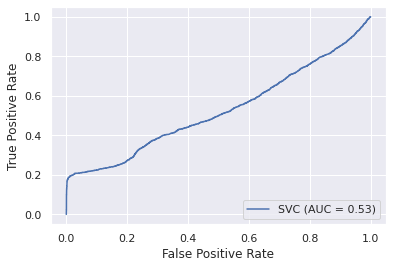

In [6]:
informe.imprimir_metricas(gscv_lineal, X_test, y_test, 'SVM con kernel lineal:')
roc = plot_roc_curve(gscv_lineal.best_estimator_, X_test, y_test)

## Modelo 2: Kernel polinomial

In [7]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='poly', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'degree': [2, 3]}

gscv_poly = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_poly.best_params_

{'C': 0.1, 'degree': 2, 'gamma': 'auto'}

### Métricas


Resultados SVM con kernel polinomial:
    Mejores hiperparámetros: {'C': 0.1, 'degree': 2, 'gamma': 'auto'}
    Métrica AUC ROC: 0.73
    Otras metricas:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      9888
           1       0.62      0.21      0.31      3137

    accuracy                           0.78     13025
   macro avg       0.71      0.58      0.59     13025
weighted avg       0.75      0.78      0.73     13025



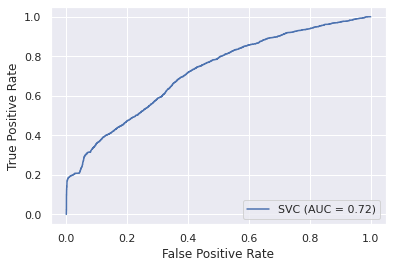

In [8]:
informe.imprimir_metricas(gscv_poly, X_test, y_test, 'SVM con kernel polinomial:')
roc = plot_roc_curve(gscv_poly.best_estimator_, X_test, y_test)

## Modelo 3: Kernel radial

In [9]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='rbf', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}

gscv_rbf = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_rbf.best_params_

{'C': 10, 'gamma': 'auto'}

### Métricas


Resultados SVM con kernel radial:
    Mejores hiperparámetros: {'C': 10, 'gamma': 'auto'}
    Métrica AUC ROC: 0.74
    Otras metricas:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87      9888
           1       0.59      0.31      0.41      3137

    accuracy                           0.78     13025
   macro avg       0.70      0.62      0.64     13025
weighted avg       0.76      0.78      0.76     13025



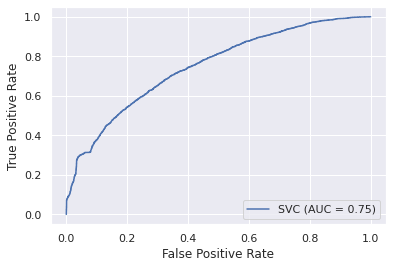

In [10]:
informe.imprimir_metricas(gscv_rbf, X_test, y_test, 'SVM con kernel radial:')
roc = plot_roc_curve(gscv_rbf.best_estimator_, X_test, y_test)

## Modelo 4: Kernel sigmoideo

In [11]:
from sklearn.model_selection import GridSearchCV 
from sklearn import svm

clf = svm.SVC(kernel='sigmoid', cache_size = 400)
params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'] }

gscv_sig = GridSearchCV(
    clf, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

gscv_sig.best_params_

{'C': 10, 'gamma': 'scale'}

### Métricas


Resultados SVM con kernel sigmoideo:
    Mejores hiperparámetros: {'C': 10, 'gamma': 'scale'}
    Métrica AUC ROC: 0.52
    Otras metricas:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9888
           1       0.22      0.22      0.22      3137

    accuracy                           0.62     13025
   macro avg       0.49      0.49      0.49     13025
weighted avg       0.63      0.62      0.63     13025



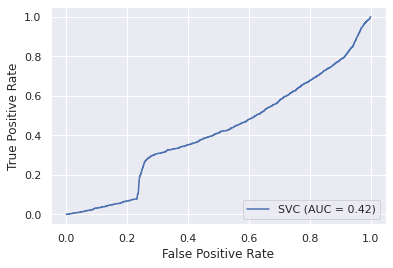

In [12]:
informe.imprimir_metricas(gscv_sig, X_test, y_test, 'SVM con kernel sigmoideo:')
roc = plot_roc_curve(gscv_sig.best_estimator_, X_test, y_test)

# Conclusión
      En base a la metrica AUC-ROC, se elige el modelo de SVM con kernel radial
      
### Informe del modelo usando los datos del test_holdout

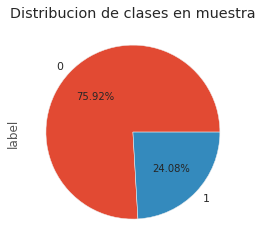

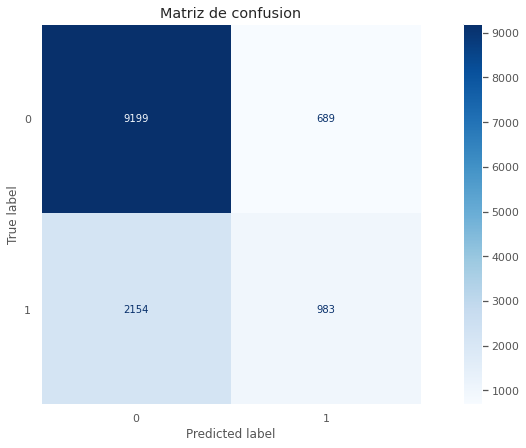

Métricas:
Resultados SVM con kernel sigmoideo:
    Mejores hiperparámetros: {'C': 10, 'gamma': 'scale'}
    Métrica AUC ROC: 0.52
    Otras metricas:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      9888
           1       0.22      0.22      0.22      3137

    accuracy                           0.62     13025
   macro avg       0.49      0.49      0.49     13025
weighted avg       0.63      0.62      0.63     13025



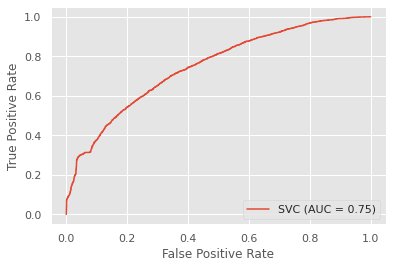

In [13]:
import sklearn

y_pred = gscv_rbf.predict(X_test)

informe.plt_distribucion_de_clases(y_test)
informe.plot_matriz_de_confusion(gscv_rbf, X_test, y_test)
roc = plot_roc_curve(gscv_rbf.best_estimator_, X_test, y_test)
print('Métricas:')
informe.imprimir_metricas(gscv_sig, X_test, y_test, 'SVM con kernel sigmoideo:')

## Conclusiones de las métricas observadas de los datos de test_holdout

- accuracy:

        El modelo clasifica los datos de forma correcta en aproximadamente un 75%, viendo la distribucion de clases de la muestra se observa que el 0 es la clase mayoritaria con una proporción de aproximadamente 76%.
    
    
- precisión:

        La fracción de predicciones de 0's que realmente eran 0's fue de aproximadamente 87% y la fracción de predicciones de 1's que realmente eran 1's fue del 78% 


- recall:

        Los 0's reales detectados fueron aproximadamente el 93%, y los 1's reales detectados fueron del 56%. Viendo este resultado en conjunto con la precisión, se entiende que el modelo es mejor prediciendo los 0's que los 1's 


- f1 score:
   
       La calidad del modelo es de 41% en terminos del recall y la precision asi como el balance entre ambas
       
       
- matriz de confusion:

        Se puede ver que las predicciones mayoritarias caen en la diagonal principal, lo cual es una buena caracteristica de una matriz de confusión. sin embargo para los 1's, las dos columnas estan demasiado balanceadas, lo cual ya se sabia ya que en el resultado de recall para los 1's no era muy bueno.
        
        
- UAC ROC:

        Esta métrica indica que el modelo es bueno distinguiendo clases en un 75%. Este valor será utilizado para decidir sobre la elección de este modelo.


# Final test

In [14]:
df_test = informe.get_df_test()

#preprocesamiento
df_test = preprocessing.ordinal_encode(df_test)
df_test = preprocessing.dummy_variables(df_test)
df_test = preprocessing.normalizar(df_test)
df_test = preprocessing.pca(df_test, n_components=4)

y_pred = gscv_rbf.predict(df_test)
informe.save_pred(y_pred, 'svm')